In [40]:
import sys
sys.path.append("../")

%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt

import smt.sparsify
import smt.utility
from smt.sparsify import solvers
from smt.sparsify import dictionary_update
import cv2
import pyrtools as pt
from matplotlib.pyplot import imshow, show

In [2]:
"""
# Load video data from a npz file
n_frames = 4000
frame_rate = 4
size = 128
original_w = 1280
original_h = 720

video = utility.load_video("data/forest_video.mp4", n_frames+1000)[
        1000::frame_rate,
        #int(original_h/2 - size/2): int(original_h/2 + size/2),
        #int(original_w/2 - size/2): int(original_w/2 + size/2)
        :,
        int(original_w/2 - original_h/2): int(original_w/2 + original_h/2),
]
video.shape
"""

'\n# Load video data from a npz file\nn_frames = 4000\nframe_rate = 4\nsize = 128\noriginal_w = 1280\noriginal_h = 720\n\nvideo = utility.load_video("data/forest_video.mp4", n_frames+1000)[\n        1000::frame_rate,\n        #int(original_h/2 - size/2): int(original_h/2 + size/2),\n        #int(original_w/2 - size/2): int(original_w/2 + size/2)\n        :,\n        int(original_w/2 - original_h/2): int(original_w/2 + original_h/2),\n]\nvideo.shape\n'

In [33]:
#np.save("../data/normalized.npy", normalized)

In [61]:
downsampled = np.load("../data/downsampled.npy")

In [ ]:
from smt.utility import animate
animate(downsampled, path="data/downsampled.mp4")

In [62]:
from smt.preprocess import whitening
whitened = whitening(downsampled)

In [65]:
from smt.preprocess import normalize
normalized = normalize(whitened, method='rgb')

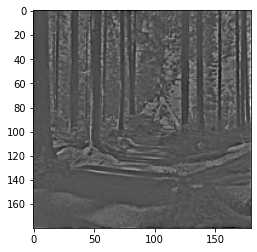

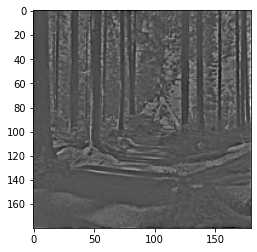

In [66]:
imshow(normalized[100], cmap='gray')
show()
imshow(whitened[100], cmap='gray')
show()

In [19]:
animate(normalized, path="data/normalized.mp4")

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/pyrtools/tools/display.py:119: UserWarning: Ignoring dpi argument: with PyrFigure, we do not use the dpi argument for saving, use dpi_multiple instead (this is done to prevent aliasing)
  warnings.warn("Ignoring dpi argument: with PyrFigure, we do not use the dpi argument"


In [10]:
#data = whitened
#np.save("data/whitened.npy", data)

In [34]:
data = np.load("../data/normalized.npy")

In [7]:
#np.save("dictionary.npy", basis1.detach().cpu().numpy())

In [8]:
basis1 = torch.tensor(np.load("../data/dictionary.npy")).cuda()

In [9]:
# data_shape: (n_timesteps, x, y)
num_patches = (data.shape[1] // 16) * (data.shape[2] // 16)

# Create an empty array to store the patches
patched_data = np.empty((data.shape[0], num_patches, 16 * 16))

# Iterate through each data point
for i in range(data.shape[0]):
    # Iterate through rows of patches
    for j in range(data.shape[1] // 16):
        # Iterate through columns of patches
        for k in range(data.shape[2] // 16):
            # Extract the 16x16 patch and reshape it to a 1D array
            patch = data[i, j * 16:(j + 1) * 16, k * 16:(k + 1) * 16].flatten()
            # Assign the patch to the appropriate location in the new array
            patch_index = j * (data.shape[2] // 16) + k
            patched_data[i, patch_index, :] = patch

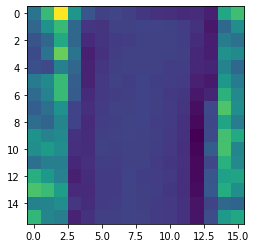

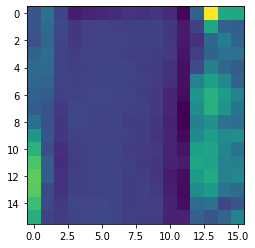

In [35]:
imshow(patched_data[0, 0].reshape(16, 16))
show()
imshow(patched_data[2, 0].reshape(16, 16))
show()

In [52]:
def ISTA_PN(I,basis,lambd,num_iter,eta=None, useMAGMA=True):
    # This is a positive-negative PyTorch-Ver ISTA solver
    # MAGMA uses CPU-GPU hybrid method to solve SVD problems, which is great for single task. When running multiple jobs, this flag should be turned off to leave the svd computation on only GPU.
    dtype = basis.type()
    batch_size=I.size(1)
    M = basis.size(1)
    if eta is None:
        if useMAGMA:
            L = torch.max(torch.linalg.eigvalsh(torch.mm(basis, basis.t()), UPLO='U'))
            eta = 1./L
        else:
            eta = 1./cp.linalg.eigvalsh(cp.asarray(torch.mm(basis,basis.t()).cpu().numpy())).max().get().reshape(1)
            eta = torch.from_numpy(eta.astype('float32')).cuda()

    #Res = torch.zeros(I.size()).type(dtype)
    #ahat = torch.zeros(M,batch_size).type(dtype)
    Res = torch.zeros(I.size(), device='cuda')
    ahat = torch.zeros(M,batch_size, device='cuda')

    for t in range(num_iter):
        ahat = ahat.add(eta * basis.t().mm(Res))
        ahat_sign = torch.sign(ahat)
        ahat.abs_()
        ahat.sub_(eta * lambd).clamp_(min = 0.)
        ahat.mul_(ahat_sign)
        Res = I - torch.mm(basis,ahat)
    return ahat, Res

In [53]:
np.any(np.isnan(data))

False

In [ ]:
xdim = ydim = 16 #Patch size
dictionary_size = 2048
batch_size = 128
steps = 3_000_000

basis1 = torch.randn([xdim*ydim, dictionary_size]).cuda()
basis1 = basis1.div_(basis1.norm(2,0))

ACT_HISTORY_LEN = 300
HessianDiag = torch.zeros(dictionary_size).cuda()
ActL1 = torch.zeros(dictionary_size).cuda()
signalEnergy = 0.
noiseEnergy = 0.

edgeBuff = 5
spRange_t = data.shape[0]
spRange_x = data.shape[1] - xdim - edgeBuff * 2
spRange_y = data.shape[2] - ydim - edgeBuff * 2

I = np.zeros([xdim*ydim, batch_size]).astype('float32')
totalSteps1 = 0

In [70]:
for i in range(totalSteps1,steps):
    for j in range(batch_size):
        xIdx = np.floor(np.random.rand()*spRange_x + edgeBuff).astype(int)
        yIdx = np.floor(np.random.rand()*spRange_y + edgeBuff).astype(int)
        sIdx = np.floor(np.random.rand()*spRange_t).astype(int)
        I[:,j] = data[sIdx,xIdx:xIdx+xdim,yIdx:yIdx+ydim].reshape([xdim*ydim])
    I_cuda = torch.from_numpy(I).cuda()

    #Sparse Coefficients Inference by ISTA
    #For positive-only codes, use ISTA
    #For positive-negative codes, use ISTA_PN
    ahat, Res = ISTA_PN(I_cuda, basis1, 0.08, 1000)
    #ahat, Res = sparsify.ISTA(I_cuda, basis1, 0.03, 1000)

    #Statistics Collection
    ActL1 = ActL1.mul((ACT_HISTORY_LEN-1.0)/ACT_HISTORY_LEN) + ahat.abs().mean(1)/ACT_HISTORY_LEN
    HessianDiag = HessianDiag.mul((ACT_HISTORY_LEN-1.0)/ACT_HISTORY_LEN) + torch.pow(ahat,2).mean(1)/ACT_HISTORY_LEN

    signalEnergy = signalEnergy*((ACT_HISTORY_LEN-1.0)/ACT_HISTORY_LEN) + torch.pow(I_cuda,2).sum()/ACT_HISTORY_LEN
    noiseEnergy = noiseEnergy*((ACT_HISTORY_LEN-1.0)/ACT_HISTORY_LEN) + torch.pow(Res,2).sum()/ACT_HISTORY_LEN
    snr = signalEnergy/noiseEnergy

    #Dictionary Update
    totalSteps1 = totalSteps1 + 1
    basis1 = dictionary_update.quadraticBasisUpdate(basis1, Res, ahat, 0.001, HessianDiag, 0.01)

    #Print Information
    if i % 100 == 0:
        print(f"step: {int(totalSteps1)} | S-N-R: {snr.item()} | \n"
              f"Hessian min: {HessianDiag.min()}, max: {HessianDiag.max()} | \n"
              f"Act min: {ActL1.min()}, max: {ActL1.max()}, sum: {ActL1.sum()} \n"
              "-------------------------------------------------------------- ")

step: 3401 | S-N-R: 412.5528869628906 | 
Hessian min: 0.00010336092236684635, max: 0.0007901581702753901 | 
Act min: 0.002121909987181425, max: 0.013877944089472294, sum: 14.423198699951172 
-------------------------------------------------------------- 
step: 3501 | S-N-R: 410.66400146484375 | 
Hessian min: 0.00010699081758502871, max: 0.0007910171407274902 | 
Act min: 0.0021944872569292784, max: 0.013666441664099693, sum: 14.408414840698242 
-------------------------------------------------------------- 
step: 3601 | S-N-R: 407.87164306640625 | 
Hessian min: 0.00011844225809909403, max: 0.0007651293417438865 | 
Act min: 0.002355283359065652, max: 0.013428626582026482, sum: 14.418655395507812 
-------------------------------------------------------------- 


KeyboardInterrupt: 

In [28]:
reshaped_patches = np.transpose(patched_data.reshape(-1, 16*16), (1, 0))
print(reshaped_patches.shape)
A, _ = ISTA_PN(torch.from_numpy(reshaped_patches[:, :12100]).float().cuda(), basis1, 0.08, 1000)
print(A.shape)

(256, 121000)


<ipython-input-27-f76e7c70fee1>:17: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:83.)
  Res = torch.cuda.FloatTensor(I.size()).fill_(0)


torch.Size([2048, 12100])


In [30]:
A

tensor([[nan, nan, nan,  ..., 0., 0., nan],
        [nan, nan, nan,  ..., -0., 0., nan],
        [nan, nan, nan,  ..., 0., -0., nan],
        ...,
        [nan, nan, nan,  ..., 0., 0., nan],
        [nan, nan, nan,  ..., -0., 0., nan],
        [nan, nan, nan,  ..., -0., 0., nan]], device='cuda:0')

In [12]:
def natural_nghb_matrix(A, scheme='temporal', spatial_range=3, spatial_weight = 1, 
                        temporal_range=1, temporal_causality=False, temporal_weight = 1):
    dims = A.shape[0]
    n_patches = A.shape[1]
    offset = 121
    NB = torch.zeros(n_patches, n_patches) # initialize
    NB.fill_diagonal_(1) # set diagonal (i, i) to 1

    if scheme == 'temporal' or scheme == 'spatiotemporal':
        # A: (sparse dimensions, n data points)
        # find the previous (and the next if temporal_causality=False) sequence elements for the patch
        # get them in ((x, y), weight->delta_t) format
        for i in range(n_patches):
            for t in range(temporal_range):
                backward = i - (t+1) * offset
                if backward > 0:
                    NB[i, backward] = -0.5
                    
                if not temporal_causality:
                    forward = i + (t+1) * offset 
                    if forward < n_patches:
                        NB[i, forward] = -0.5
        return NB.cuda()
                
        # if spatiotemporal multiply by temporal_weight
        # set (x, y) of NB
        
    if scheme == 'spatial' or scheme == 'spatiotemporal':
        raise NotImplementedError()
        # find the neighbouring pathces spatially
        # get them in ((x, y), distance) format
        # if spatiotemporal multiply by spatial_weight
        # set (x, y) of NB

In [13]:
#A, _ = ISTA_PN(torch.from_numpy(np.reshape(data, [xdim*y_dim, -1])).cuda(), basis1, 0.08, 1000)
#N = A.shape[1] # Total number of datapoints
V = torch.cov(A)  # covariance matrix of A =? 1/N * (A @ A.T)
D = natural_nghb_matrix(A, scheme="temporal") # Second-order differential operator, any clustering and neighbour search can be used

In [16]:
print(V.isnan().any())
print(D.isnan().any())
print(A.isnan().any())
print(A.T.isnan().any())
print(D.T.isnan().any())

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(False, device='cuda:0')


In [ ]:
# deterministic solution
# drawbacks:
#  - unnecessary ordering among different dimensions
#  - learned functional embedding tends to be global
#  - not online, does not allow other constraints

def get_trailing_eigenvectors(U, num_eigenvectors):
    """
    Get the trailing eigenvectors of a matrix U.

    Parameters:
    - U: The input matrix.
    - num_eigenvectors: Number of trailing eigenvectors to retrieve.

    Returns:
    - trailing_eigenvectors: Matrix containing the trailing eigenvectors.
    """
    # Perform eigenvalue decomposition
    eigenvalues, eigenvectors = torch.linalg.eig(U)

    # Sort eigenvalues and corresponding eigenvectors
    eigenvalues, indices = torch.sort(eigenvalues[:, 0])
    eigenvectors = eigenvectors[:, indices]

    # Select the trailing eigenvectors
    trailing_eigenvectors = eigenvectors[:, -num_eigenvectors:]

    return trailing_eigenvectors


Q = torch.sqrt(V).inverse() @ A @ D @ D.T @ A.T @ torch.sqrt(V).inverse()
U = get_trailing_eigenvectors(Q, 3)
P =  U @ torch.sqrt(V).inverse()

In [ ]:
# SGD solution
n_epochs = 10 # optimization steps
lr = 0.01 # learning rate
gamma = 1 # weight of optimization objective
gamma_reg = None # weight of regularization
P = torch.rand(200, 2048).cuda() # initialize

def shrinkage(A, P):
    # shrink each entry in the j-th column of P by gamma_reg * <a_j> 
    # a_j is the j-th column of A
    # <.> denotes inner product
    pass


for epoch in range(n_epochs):
        # whitened gradient computed on mini-batch
        P = -2 * gamma * lr * P @ A @ D @ D.T @ A.T @ V.sqrt().inverse()
        print("ok")
        #P = shrinkage(A, P) # regularization
        P = torch.sqrt(P @ V @ P.T).inverse() @ P # orthogonalization      

In [ ]:
Beta = P @ A
Beta.shape

In [ ]:
from matplotlib.pyplot import imshow, show
imshow(basis1[:, 1].reshape(32, 32).detach().cpu().numpy())
show()

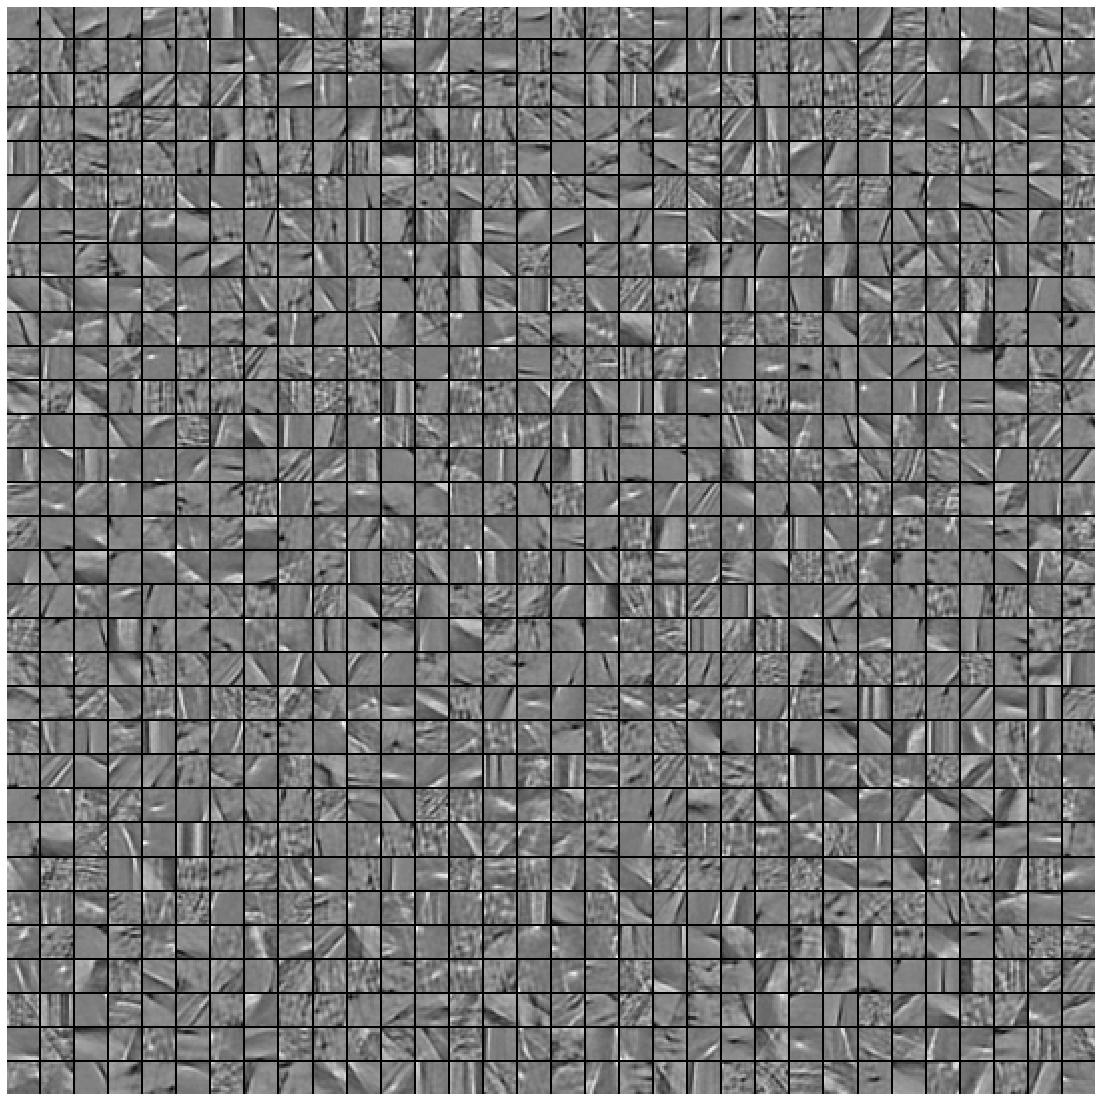

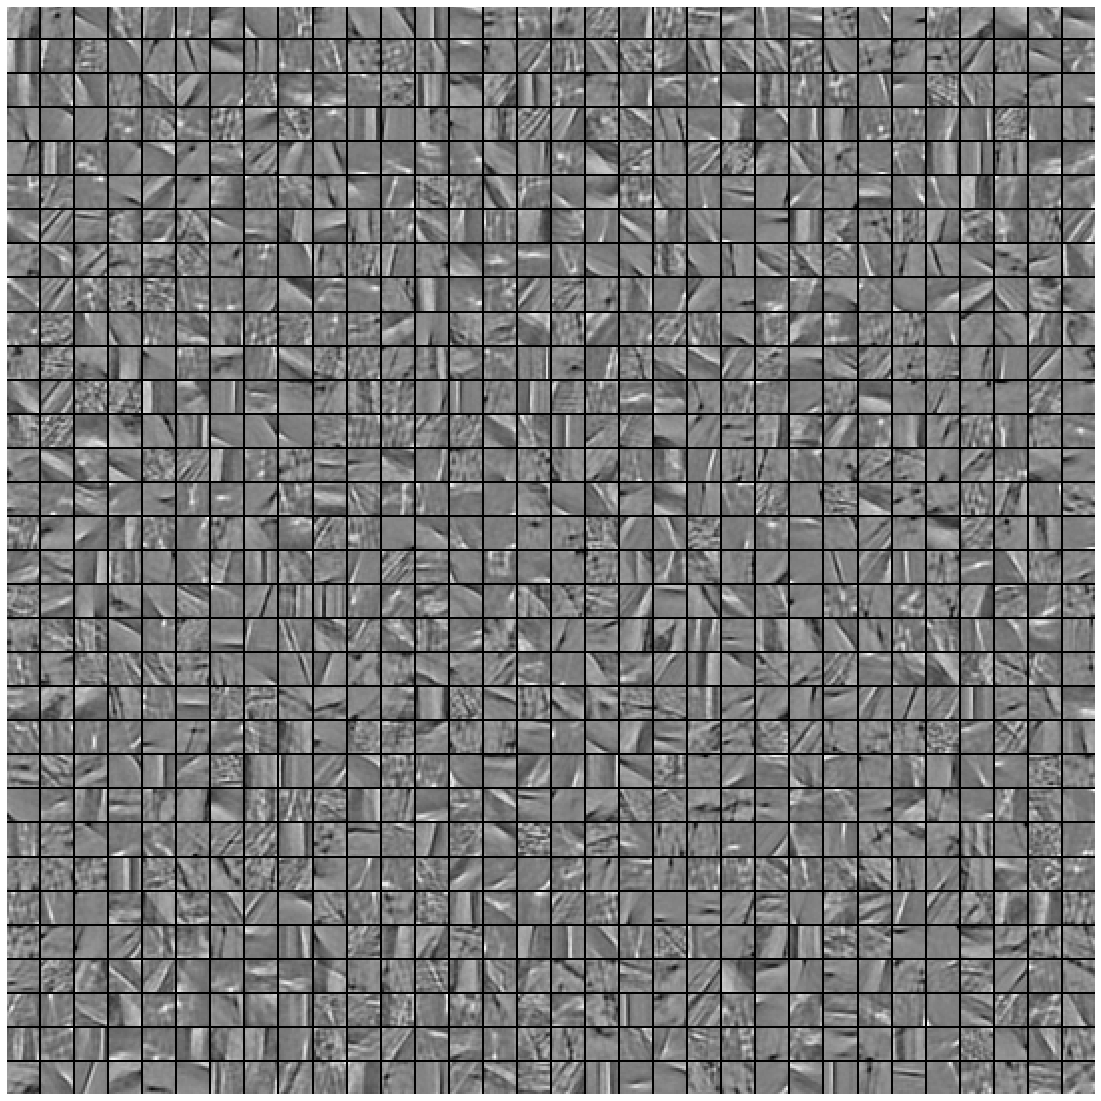

In [71]:
#Dictionary Visualization
basis1_host = basis1.cpu().numpy()
fig = plt.figure(figsize = (20,20))
ax = fig.gca()
smt.utility.displayVecArry(basis1_host,32,32,ax=ax,title="",equal_contrast=True) #Visualize first 1024 Dictionary Elements
fig = plt.figure(figsize = (20,20))
ax = fig.gca()
smt.utility.displayVecArry(basis1_host[:,1024:],32,32,ax=ax,title="",equal_contrast=True) #Visualize first 1024 Dictionary Elements

In [ ]:
np.savez("basis1_IMAGES_Vanhateren_10x.npz", basis1 = basis1_host)